### Pulls out the relevant isaura information for visualisation

In [101]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf

from invisible_cities.io.dst_io import load_dst
import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines


import core.functions as func

import imageio

In [102]:


def add_binclass(mchits, mcpart, signal_creator = 'conv'):
    '''
    Adds binary class to each hit depending on if its event is considered as signal or background.
    The two possible classes for the events are:
        0 - background
        1 - signal
    Process:
        - Selects particles that had any hit in the active.
        - Selects only e-/e+
        - If there are 2 particles in an event that are created by a certain process,
          labels the event as signal. 
        - Otherwise, as background.
    For double escape data, the creator process is signal_creator = 'conv' (i.e. 208Tl data).
    For 0nubb data, the creator process is signal_creator = 'none'.

    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file, from table MC/hits.
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file, from table MC/particles.
        signal_creator: STR
    If 'conv', signal will be the double escape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        mchits_binclass: DATAFRAME
    The mchits df with a new column containing the binclass.
    '''

    # Select only those particles that actually left any hit in the active
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id'])
    hits_part = hits_part[mcpart.columns].drop_duplicates()

    # Select e+/e-
    hits_part = hits_part[np.isin(hits_part.particle_name, ['e+', 'e-'])]
    
    # Create a selector of signal/background
    selector = lambda x: 1 if int(sum(x == signal_creator)) == 2 else 0

    class_label = hits_part.groupby('event_id').creator_proc.apply(selector).astype(int)
    class_label.name = 'binclass'
    mchits_binclass  = pd.merge(mchits, class_label, on = 'event_id')
    
    return mchits_binclass

def get_extremes(file, signal_creator = 'conv'):
    '''
    Gets the extremes of the MC track. 
    It also gives them a label, called 'ext', which can be:
        1 - end   of background track, random for signal track
        2 - start of background track, random for signal track (for similarity with 'blob2')
    Process:
        - Do binary classification of the events
        - Select the main particles in the event (e+e- or e-e- for signal,
          the most energetic e- for background)
        - Select the extremes (last hits for signal, first/last for background)
    
    Args:
        file: STR
    Path to any file with MC information.
        signal_creator: STR
    If 'conv', signal will be the double scape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        track_ext: DATAFRAME
    The extreme hits of each event with a label.
    '''

    mcpart = load_dst(file, 'MC', 'particles')
    mchits = load_dst(file, 'MC', 'hits')
    mchits = mchits[mchits.label == 'ACTIVE']
    
    # Add binclass label to the hits
    mchits_label = add_binclass(mchits, mcpart, signal_creator = signal_creator)
    # Add to each hit the particle information
    hits_part = pd.merge(mchits_label, mcpart, on = ['event_id', 'particle_id'])
    # Do the sum on the energy so we can choose the most energetic e- in a bkg event
    per_part_info = hits_part.groupby(['event_id',
                                        'particle_id',
                                        'particle_name',
                                        'binclass',
                                        'creator_proc']).agg({'energy':[('track_ener', sum)], 'hit_id':[('nhits', len)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)

    # Select each type of particle
    ## Signal
    particles_sig = per_part_info[(per_part_info.binclass == 1) &\
                                    np.isin(per_part_info.particle_name, ['e+', 'e-']) &\
                                    (per_part_info.creator_proc == signal_creator)]
    ## Background
    particles_bkg = per_part_info[(per_part_info.binclass == 0) &\
                                    (per_part_info.particle_name == 'e-') &\
                                    (per_part_info.creator_proc.isin(['compt', 'phot', 'none']))]

    particles_bkg = particles_bkg.loc[particles_bkg.groupby('event_id').track_ener.idxmax()]

    # Search for the extremes
    ## Signal
    hits_sig = pd.merge(mchits_label, particles_sig)
    track_ext_sig = hits_sig.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop = True)
    track_ext_sig['ext'] = track_ext_sig.groupby('event_id').cumcount() + 1

    ## Background
    hits_bkg = pd.merge(mchits_label, particles_bkg)

    track_start_bkg = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()]).reset_index(drop=True)
    track_end_bkg   = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop=True)

    ### asigned this label so 2 is like "blob2" 
    track_start_bkg['ext'] = 2
    track_end_bkg['ext']   = 1

    # Join all
    track_ext_bkg = pd.concat([track_start_bkg, track_end_bkg])
    track_ext = pd.concat([track_ext_bkg, track_ext_sig]).sort_values('event_id')
    return track_ext


### read in isaura data

In [176]:
path = 'data/'
tracking = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'Tracking/Tracks')
df = pd.read_hdf(path + 'beersheba_1_208Tl.h5', 'DECO/Events')
events = np.unique(df.event.to_numpy())

# also load in MC
dfMC = mcio.load_mchits_df(path + 'isaura_1_208Tl.h5').reset_index()
eventsMC = np.unique(dfMC.event_id.to_numpy())
infoMC = pd.read_hdf(path + 'isaura_1_208Tl.h5', 'MC/particles')

## MC extremes from Martins code
mc_extr = get_extremes(path + 'isaura_1_208Tl.h5')

In [104]:
display(df)
display(dfMC)

display(tracking)
[x for x in tracking.columns.to_list()]

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
0,0,0.0,365.875,-194.425,773.807738,0.000003,368.346366,-174.196321,1.373371e+06,0,0,0
1,0,0.0,365.875,-193.425,773.807738,0.000003,368.346366,-174.196321,1.373371e+06,0,0,0
2,0,0.0,366.875,-195.425,773.807738,0.000005,368.346366,-174.196321,1.373371e+06,0,0,0
3,0,0.0,366.875,-194.425,773.807738,0.000006,368.346366,-174.196321,1.373371e+06,0,0,0
4,0,0.0,366.875,-193.425,773.807738,0.000006,368.346366,-174.196321,1.373371e+06,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2865767,648,2.0,118.875,-51.425,724.623506,0.000015,104.680861,-60.381546,6.488070e+08,0,0,0
2865768,648,2.0,119.875,-55.425,724.623506,0.000017,104.680861,-60.381546,6.488070e+08,0,0,0
2865769,648,2.0,119.875,-54.425,724.623506,0.000021,104.680861,-60.381546,6.488070e+08,0,0,0
2865770,648,2.0,119.875,-53.425,724.623506,0.000020,104.680861,-60.381546,6.488070e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,0,39,0,386.361053,-182.384506,781.322083,2.307219,0.000069,ACTIVE
1,0,39,1,261.051025,-37.941269,863.623169,3.568978,0.000011,ACTIVE
2,0,47,0,214.329819,210.628296,797.141357,4.448271,0.000221,ACTIVE
3,0,62,0,214.330002,210.628357,797.141479,4.448344,0.000023,ACTIVE
4,0,61,0,214.329865,210.628296,797.141418,4.448293,0.000045,ACTIVE
...,...,...,...,...,...,...,...,...,...
117403,324,46,7,131.310883,-206.131348,44.084183,2.968418,0.001434,ACTIVE
117404,324,46,8,131.303696,-206.124832,44.088520,2.968658,0.001053,ACTIVE
117405,324,46,9,131.300247,-206.122803,44.081619,2.968858,0.001334,ACTIVE
117406,324,46,10,131.297440,-206.118759,44.081928,2.969004,0.001585,ACTIVE


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,0.430137,42.219578,36,4200,3,351.875,-207.425,773.807738,...,785.041687,392.553402,-193.996445,778.724004,0.325842,0.274363,0.170068,8.909091,8.938776,8.985429
1,0,1,0.100154,15.492306,7,718,3,253.875,-46.425,857.615981,...,862.386702,265.362191,-36.377118,868.992086,0.100154,0.100154,0.100154,8.909091,8.938776,8.985429
2,0,2,0.019781,15.492306,2,71,3,214.875,205.575,795.273675,...,801.389334,218.590523,211.170733,797.181647,0.019781,0.019781,0.019781,8.909091,8.938776,8.985429
3,2,0,2.199912,499.762729,351,21994,2,125.875,-95.425,505.002684,...,547.067286,291.968568,179.039013,529.855947,0.400130,0.067598,0.000000,8.681818,9.000000,8.834166
4,2,1,0.153573,21.186776,6,847,2,111.875,-121.425,401.142328,...,405.858757,133.016578,-115.886194,406.039125,0.153573,0.153573,0.153573,8.681818,9.000000,8.834166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,646,1,0.185982,20.843466,9,1055,3,206.875,167.575,595.195716,...,612.465506,227.378097,176.879945,602.468363,0.185982,0.185982,0.185982,8.642857,8.400000,8.611381
635,646,2,0.029640,8.400000,2,139,3,319.875,153.575,565.490166,...,566.977897,322.337162,162.249784,566.635683,0.029640,0.029640,0.029640,8.642857,8.400000,8.611381
636,648,0,0.480633,33.379377,19,1617,3,110.875,-229.425,34.134343,...,36.699524,135.346019,-224.123951,50.135720,0.451764,0.450675,0.421806,9.000000,8.666667,8.967392
637,648,1,0.124540,24.046043,9,771,3,59.875,-72.425,665.535675,...,668.477644,69.636085,-68.139340,671.791432,0.124540,0.124540,0.124540,9.000000,8.666667,8.967392


['event',
 'trackID',
 'energy',
 'length',
 'numb_of_voxels',
 'numb_of_hits',
 'numb_of_tracks',
 'x_min',
 'y_min',
 'z_min',
 'r_min',
 'x_max',
 'y_max',
 'z_max',
 'r_max',
 'x_ave',
 'y_ave',
 'z_ave',
 'r_ave',
 'extreme1_x',
 'extreme1_y',
 'extreme1_z',
 'extreme2_x',
 'extreme2_y',
 'extreme2_z',
 'blob1_x',
 'blob1_y',
 'blob1_z',
 'blob2_x',
 'blob2_y',
 'blob2_z',
 'eblob1',
 'eblob2',
 'ovlp_blob_energy',
 'vox_size_x',
 'vox_size_y',
 'vox_size_z']

In [106]:
evt_num = 305

# select an event
evt = events[evt_num]
evtMC = eventsMC[evt_num]
print("Selected event: {} ({} MC)".format(evt, evtMC))

data = df[df.event == evt]
track_data = tracking[tracking.event == evt]
dataMC = dfMC[dfMC.event_id == evtMC]
evnt_infoMC = infoMC[infoMC.event_id == evtMC]

evnt_mc_extr = mc_extr[mc_extr.event_id == evtMC]

display(data)
display(dataMC)
display(track_data)
display(evnt_infoMC)
display(evnt_mc_extr)

# check energy
print(f'Checking track energy and Beersheba energy:\nBeersheba E: {data.E.sum():.5f} MeV\nTrack E: {track_data.energy.values[0]:.5f}')

Selected event: 610 (305 MC)


,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
2699042,610,0.0,101.875,-143.425,106.496234,0.000013,120.851592,-139.648331,6.116410e+08,0,0,0
2699043,610,0.0,101.875,-142.425,106.496234,0.000015,120.851592,-139.648331,6.116410e+08,0,0,0
2699044,610,0.0,101.875,-141.425,106.496234,0.000016,120.851592,-139.648331,6.116410e+08,0,0,0
2699045,610,0.0,101.875,-140.425,106.496234,0.000017,120.851592,-139.648331,6.116410e+08,0,0,0
2699046,610,0.0,101.875,-139.425,106.496234,0.000018,120.851592,-139.648331,6.116410e+08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2710435,610,0.0,150.875,-117.425,284.586783,0.000036,120.851592,-139.648331,6.116410e+08,0,0,0
2710436,610,0.0,151.875,-120.425,284.586783,0.000030,120.851592,-139.648331,6.116410e+08,0,0,0
2710437,610,0.0,151.875,-119.425,284.586783,0.000035,120.851592,-139.648331,6.116410e+08,0,0,0
2710438,610,0.0,151.875,-118.425,284.586783,0.000033,120.851592,-139.648331,6.116410e+08,0,0,0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
110205,305,20,0,153.514420,-111.304398,282.043762,2.052215,0.000001,ACTIVE
110206,305,24,0,153.514221,-111.304375,282.043823,2.052292,0.000021,ACTIVE
110207,305,23,0,153.514511,-111.304405,282.043823,2.052244,0.000048,ACTIVE
110208,305,22,0,153.416458,-112.225929,281.668335,2.055655,0.001210,ACTIVE
110209,305,22,1,153.226273,-113.067741,281.170685,2.059081,0.011539,ACTIVE
...,...,...,...,...,...,...,...,...,...
110834,305,87,6,148.243591,-123.155968,270.583099,2.142875,0.001287,ACTIVE
110835,305,87,7,148.244278,-123.168930,270.582611,2.143149,0.002435,ACTIVE
110836,305,87,8,148.249252,-123.168678,270.587158,2.143328,0.000916,ACTIVE
110837,305,87,9,148.245956,-123.168221,270.590485,2.143471,0.001818,ACTIVE


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
602,610,0,1.584959,218.821703,181,11153,1,79.875,-171.425,106.496234,...,110.409625,149.537072,-111.739132,280.965146,0.40519,0.330027,0.0,9.0,8.125,8.904527


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
24819,305,1,Tl208,True,0,397.162811,394.625061,531.936218,0.000000,397.162811,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
24820,305,4,e-,False,1,397.162811,394.625061,531.936218,0.000856,398.880493,...,-0.086149,-0.573830,-0.397886,-0.000000,0.000000,-0.000000,0.358562,15.567177,RadioactiveDecay,eIoni
24821,305,3,anti_nu_e,False,1,397.162811,394.625061,531.936218,0.000856,-1007.312622,...,-0.143388,1.235881,-0.730166,-0.143388,1.235881,-0.730166,1.442603,14130.206055,RadioactiveDecay,Transportation
24822,305,2,Pb208[3197.711],False,1,397.162811,394.625061,531.936218,0.000856,397.162811,...,0.229536,-0.662049,1.128049,0.000000,-0.000000,0.000000,0.000005,0.000000,RadioactiveDecay,RadioactiveDecay
24823,305,6,gamma,False,2,397.162811,394.625061,531.936218,0.000856,410.126373,...,0.330496,0.163993,0.451649,0.000000,0.000000,0.000000,0.583188,43.020229,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24901,305,41,e-,False,22,131.295731,-140.029587,238.106522,2.270732,131.046753,...,-0.151755,-0.105360,-0.031475,-0.000000,0.000000,0.000000,0.033281,1.391615,eIoni,eIoni
24902,305,40,e-,False,22,151.259995,-125.237213,273.506775,2.110245,150.971375,...,-0.483151,-0.190570,0.064859,0.000000,0.000000,-0.000000,0.220492,35.496811,eIoni,eIoni
24903,305,87,e-,False,40,148.260300,-123.059341,270.484802,2.139681,148.246765,...,-0.094792,0.080500,-0.036392,0.000000,0.000000,-0.000000,0.016173,0.538821,eIoni,eIoni
24904,305,21,e-,False,20,389.627472,376.425415,527.025818,0.068572,389.624573,...,-0.016117,-0.379194,0.355198,-0.000000,-0.000000,-0.000000,0.217927,0.554533,compt,eIoni


,event_id,particle_id,hit_id,x,y,z,time,energy,label,binclass,particle_name,creator_proc,track_ener,nhits,ext
286,305,22,392,103.778175,-143.292664,108.230957,3.427015,0.000212,ACTIVE,0,e-,compt,1.127284,393,1
286,305,22,0,153.416458,-112.225929,281.668335,2.055655,0.001210,ACTIVE,0,e-,compt,1.127284,393,2


Checking track energy and Beersheba energy:
Beersheba E: 1.58496 MeV
Track E: 1.58496


#### visualise blob position 

In [107]:
print(track_data.blob1_x.values[0])
print(track_data.blob1_y.values[0])
print(track_data.blob1_z.values[0])

101.81293228674151
-143.56621419506862
110.40962486787365


In [108]:
def plt_sphere(list_center, list_radius, col = 'g', label = 'template'):
  for c, r in zip(list_center, list_radius):
    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    s1 = ax.plot_surface(x+c[0], y+c[1], z+c[2], color=col, alpha=0.1*np.random.random()+0.9, zorder = 3, label = label)


def plt_MCsphere(list_center, list_radius, label = 'template', cmap = 'cm.coolwarm'):
  for c, r in zip(list_center, list_radius):
    
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)

    s1 = ax.plot_surface(x+c[0], y+c[1], z+c[2], cmap = cmap, alpha=0.1*np.random.random()+0.9, zorder = 3, label = label)


Text(0.5, 0.98, '3D_deconvolved_plot_610')

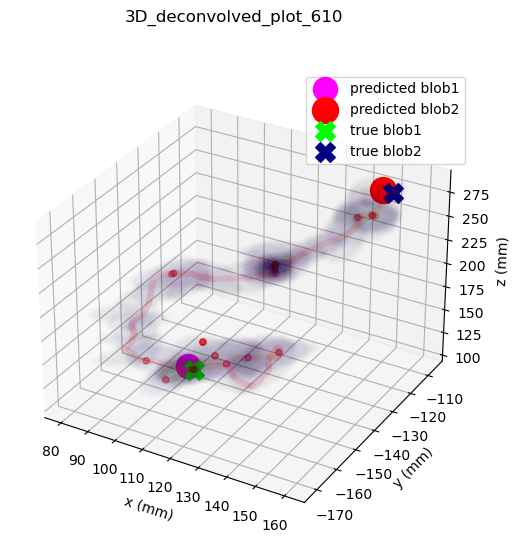

In [109]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')





x = data.X
y = data.Y
z = data.Z
e = data.E

xt = dataMC.x
yt = dataMC.y
zt = dataMC.z
et = dataMC.energy*1000

em = e > 0.00005
##p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter3D(x, y, z, c=e, alpha=0.009, cmap='viridis', zorder=1)
q = ax.scatter3D(xt, yt, zt, alpha = 0.03, color = 'red', zorder = 0)
#cb = fig.colorbar(p, ax=ax)
#cb.set_label('Energy (keV)')


ax.scatter3D(track_data.blob1_x.values[0], track_data.blob1_y.values[0], track_data.blob1_z.values[0], s = 300, c = 'fuchsia', marker = 'o', zorder = 100, label = 'predicted blob1',depthshade=False)
ax.scatter3D(track_data.blob2_x.values[0], track_data.blob2_y.values[0], track_data.blob2_z.values[0], s = 350, c = 'red', marker = 'o', zorder = 100, label = 'predicted blob2', depthshade=False)
for blb, dfext in evnt_mc_extr.groupby('ext'):

    if blb == 1:
        col = 'lime'
    else:
        col = 'navy'
    ax.scatter3D(dfext.x.values[0], dfext.y.values[0], dfext.z.values[0], s = 200, c = col, marker = 'X', label = 'true blob' + str(blb))


plt.legend()

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

#ax.view_init(20, 270)


# blob parts

fig.suptitle('3D_deconvolved_plot_' + str(evt))

#### now to make a function that:
- takes the minimum distance between blobs for a given event
- returns this as 'blob distance reco - true'

In [184]:
def blob_accuracy(mc_extremes, isaura_data):
    '''
    for a specific event, compare pairwise and select the shortest distances from each blob
    (this technically could work incorrectly, but lets hope not)

    just pass through the mc_extremes table produced in martins function, and the isaura dataframe
    each for the specific event
    '''

    # collect extrema positions
    extremes = []
    for blob, dfext in mc_extremes.groupby('ext'):
        extremes.append([dfext.x.values[0], dfext.y.values[0], dfext.z.values[0]])

    extremes = np.array(extremes)

    # collect blob positions
    b1 = np.array([isaura_data.blob1_x.values[0], isaura_data.blob1_y.values[0], isaura_data.blob1_z.values[0]])
    b2 = np.array([isaura_data.blob2_x.values[0], isaura_data.blob2_y.values[0], isaura_data.blob2_z.values[0]])

    # calculate distance between blob 1 in isaura and the MC info
    b1_xyz = b1 - extremes
    magn1 = np.linalg.norm(b1_xyz, axis = 1)

    # if first magnitude is smaller, calculate b2 with second, and vice versa
    if magn1[0] < magn1[1]:
        b2_xyz = b2 - extremes[1]
        magn2 = np.linalg.norm(b2_xyz)
        magn1 = magn1[0]
        b1_xyz = b1_xyz[0]
        # collect x_reco - x_true, for xyz
    elif magn1[0] > magn1[1]:
        b2_xyz = b2 - extremes[0]
        magn2 = np.linalg.norm(b2_xyz)
        magn1 = magn1[1]
        b1_xyz = b1_xyz[1]
    else:
        RuntimeError("magnitudes are either identical or broken, very weird case!")

    # return 'reco - true' for blob position in magnitude terms
    return ([magn1, magn2, b1_xyz, b2_xyz])

In [185]:
test = blob_accuracy(evnt_mc_extr, track_data)
print(test)

[2.9467955134227766, 3.972540813392135, array([-1.96524307, -0.27355062,  2.17866784]), array([-3.87938568,  0.48679769, -0.70318935])]


#### so now lets scale this up for the entire dataframe

In [186]:
display(tracking)
display(mc_extr)
print(f'Datasets have the same events?\n{any(tracking.event.unique()//2 == mc_extr.event_id.unique())}')

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,0.430137,42.219578,36,4200,3,351.875,-207.425,773.807738,...,785.041687,392.553402,-193.996445,778.724004,0.325842,0.274363,0.170068,8.909091,8.938776,8.985429
1,0,1,0.100154,15.492306,7,718,3,253.875,-46.425,857.615981,...,862.386702,265.362191,-36.377118,868.992086,0.100154,0.100154,0.100154,8.909091,8.938776,8.985429
2,0,2,0.019781,15.492306,2,71,3,214.875,205.575,795.273675,...,801.389334,218.590523,211.170733,797.181647,0.019781,0.019781,0.019781,8.909091,8.938776,8.985429
3,2,0,2.199912,499.762729,351,21994,2,125.875,-95.425,505.002684,...,547.067286,291.968568,179.039013,529.855947,0.400130,0.067598,0.000000,8.681818,9.000000,8.834166
4,2,1,0.153573,21.186776,6,847,2,111.875,-121.425,401.142328,...,405.858757,133.016578,-115.886194,406.039125,0.153573,0.153573,0.153573,8.681818,9.000000,8.834166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,646,1,0.185982,20.843466,9,1055,3,206.875,167.575,595.195716,...,612.465506,227.378097,176.879945,602.468363,0.185982,0.185982,0.185982,8.642857,8.400000,8.611381
635,646,2,0.029640,8.400000,2,139,3,319.875,153.575,565.490166,...,566.977897,322.337162,162.249784,566.635683,0.029640,0.029640,0.029640,8.642857,8.400000,8.611381
636,648,0,0.480633,33.379377,19,1617,3,110.875,-229.425,34.134343,...,36.699524,135.346019,-224.123951,50.135720,0.451764,0.450675,0.421806,9.000000,8.666667,8.967392
637,648,1,0.124540,24.046043,9,771,3,59.875,-72.425,665.535675,...,668.477644,69.636085,-68.139340,671.791432,0.124540,0.124540,0.124540,9.000000,8.666667,8.967392


,event_id,particle_id,hit_id,x,y,z,time,energy,label,binclass,particle_name,creator_proc,track_ener,nhits,ext
0,0,41,0,386.015442,-183.208496,781.754700,2.311199,0.000997,ACTIVE,0,e-,compt,0.410048,106,2
0,0,41,105,362.645020,-189.518906,784.826355,2.705580,0.000850,ACTIVE,0,e-,compt,0.410048,106,1
1,1,30,0,287.616669,174.407166,523.262695,0.834290,0.000689,ACTIVE,0,e-,compt,2.032449,757,2
1,1,30,756,249.659821,-56.372650,570.463135,3.436051,0.001052,ACTIVE,0,e-,compt,2.032449,757,1
2,2,77,0,-336.796265,31.777462,402.418915,2.768681,0.001164,ACTIVE,0,e-,compt,0.855303,317,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,322,17,142,-69.294395,304.592438,131.386002,2.460090,0.001294,ACTIVE,0,e-,phot,0.495191,143,1
304,323,9,0,311.686310,167.219360,526.486938,0.912233,0.002801,ACTIVE,0,e-,phot,0.232862,65,2
304,323,9,64,308.353455,164.595825,530.997131,1.118894,0.001581,ACTIVE,0,e-,phot,0.232862,65,1
305,324,37,109,118.172668,-213.672623,35.254982,3.220015,0.001148,ACTIVE,0,e-,compt,0.441807,110,1


Datasets have the same events?
True


### Problem, events with more than 1 track...we'll ignore these for the moment but there will be a solution for this.

We should make it such that the `blob_accuracy` function works for N-tracks. Currently that isn't the case.
Would need:
- array of inputs that do all combinations of arrays, Nx2 array operations
- something that then sweeps through checking which values are smallest and based on this, provides list of 'most probably blobs'

For now, select the first track in the event

In [218]:
mags = pd.DataFrame(columns = ['Event', 'blob1_magnitude', 'blob2_magnitude', 'b1_xyz', 'b2_xyz'])
rows = []

i = 0
for evt, dfs in tracking.groupby('event'):

    #print(evt)
    #display(dfs)

    energetic_track = dfs[dfs.trackID == 0]
    extr = mc_extr[mc_extr.event_id == evt//2]
    #display(extr)
    #display(energetic_track)
    
    holding = blob_accuracy(extr, energetic_track)
    rows.append({'Event': evt, 'blob1_magnitude': holding[0], 'blob2_magnitude': holding[1], 'b1_xyz': holding[2], 'b2_xyz': holding[3]})

mags = pd.concat([mags, pd.DataFrame(rows)], ignore_index=True)

display(mags)

,Event,blob1_magnitude,blob2_magnitude,b1_xyz,b2_xyz
0,0,7.647491,12.973430,"[-6.106189437450439, 4.599152995179935, 0.2153...","[6.537960048044567, -10.787948717495794, -3.03..."
1,2,32.514222,9.157729,"[22.510516646783344, 1.7565783473934573, -23.3...","[4.351899081149384, 4.631847184403, 6.59325139..."
2,4,14.261100,3.833415,"[-11.692457778087828, -5.851830121960944, 5.69...","[-2.054151931014303, 3.236403868148045, 0.0348..."
3,6,608.992010,619.563523,"[366.19579317655246, -319.6456477989702, 366.8...","[368.14857685924807, -336.53606365405074, 367...."
4,8,5.975628,34.186109,"[5.71206743911813, 1.2770223119747754, -1.2040...","[-1.4597463395983254, -31.844858733221145, 12...."
...,...,...,...,...,...
320,640,9.247886,16.585402,"[-3.203670261454846, -7.902325030613639, 3.579...","[5.1602578738161355, 15.146748765769075, -4.36..."
321,642,3.534671,20.600185,"[1.9442511474833282, 2.2229221743241965, -1.94...","[11.495405974172058, -9.126445053980802, 14.45..."
322,644,5.870487,8.374334,"[-3.1528924892589316, -4.929159074795052, 0.47...","[0.1383734959118783, 7.709468032204654, 3.2671..."
323,646,9.478795,2.860697,"[-8.327025583703232, -4.472446310471298, 0.710...","[2.238749964659064, 1.611575019342439, -0.7578..."


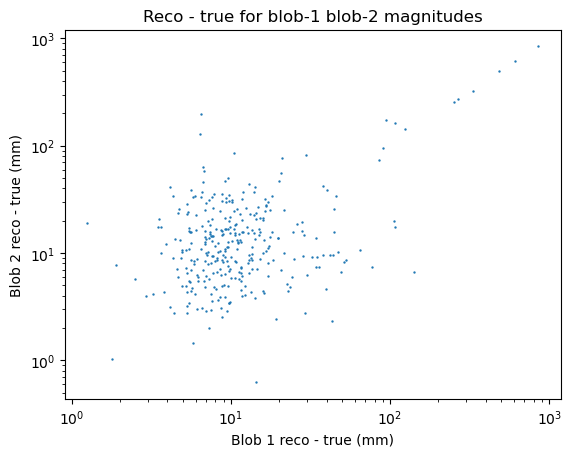

In [151]:
plt.scatter(mags.blob1_magnitude, mags.blob2_magnitude, s = 0.5)
plt.xlabel('Blob 1 reco - true (mm)')
plt.ylabel('Blob 2 reco - true (mm)')
plt.title('Reco - true for blob-1 blob-2 magnitudes')
plt.yscale('log')
plt.xscale('log')

Text(0.5, 0, 'reco - true (mm)')

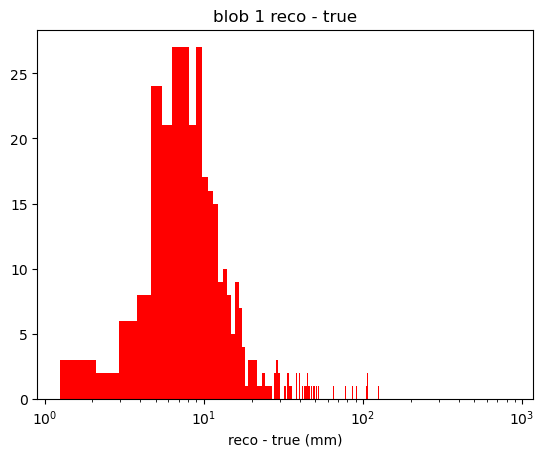

In [162]:
plt.hist(mags.blob1_magnitude, bins = 1000, label = 'blob 1', color = 'r')
plt.title('blob 1 reco - true')
plt.xscale('log')
plt.xlabel('reco - true (mm)')

Text(0.5, 0, 'reco - true (mm)')

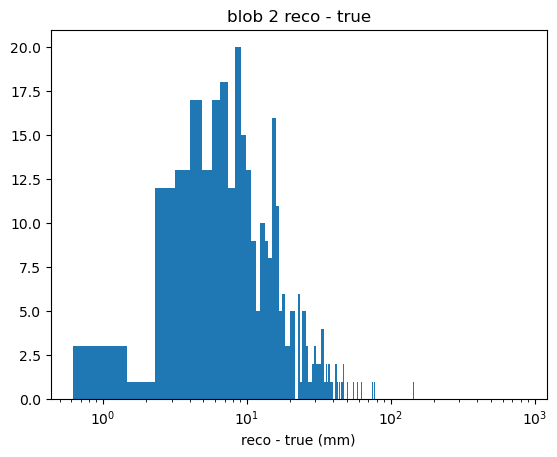

In [163]:
plt.hist(mags.blob2_magnitude, bins = 1000, label = 'blob 2')
plt.title('blob 2 reco - true')
plt.xscale('log')
plt.xlabel('reco - true (mm)')

In [197]:
print(mags.b1_xyz)
print(len(mags.b1_xyz))

0      [-6.106189437450439, 4.599152995179935, 0.2153...
1      [22.510516646783344, 1.7565783473934573, -23.3...
2      [-11.692457778087828, -5.851830121960944, 5.69...
3      [366.19579317655246, -319.6456477989702, 366.8...
4      [5.71206743911813, 1.2770223119747754, -1.2040...
                             ...                        
320    [-3.203670261454846, -7.902325030613639, 3.579...
321    [1.9442511474833282, 2.2229221743241965, -1.94...
322    [-3.1528924892589316, -4.929159074795052, 0.47...
323    [-8.327025583703232, -4.472446310471298, 0.710...
324    [-5.004838131780119, -1.546238655341483, 1.444...
Name: b1_xyz, Length: 325, dtype: object
325


Text(0.5, 0, 'reco - true (mm)')

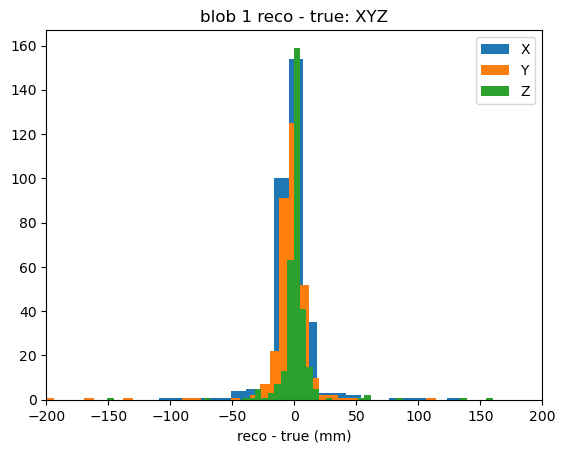

In [202]:
plt.hist([mags.b1_xyz[i][0] for i in range(len(mags.b1_xyz))], bins = 100, label = 'X')
plt.hist([mags.b1_xyz[i][1] for i in range(len(mags.b1_xyz))], bins = 100, label = 'Y')
plt.hist([mags.b1_xyz[i][2] for i in range(len(mags.b1_xyz))], bins = 100, label = 'Z')
plt.title('blob 1 reco - true: XYZ')
#plt.xscale('log')
plt.xlim([-200, 200])
plt.legend()
plt.xlabel('reco - true (mm)')

Text(0.5, 0, 'reco - true (mm)')

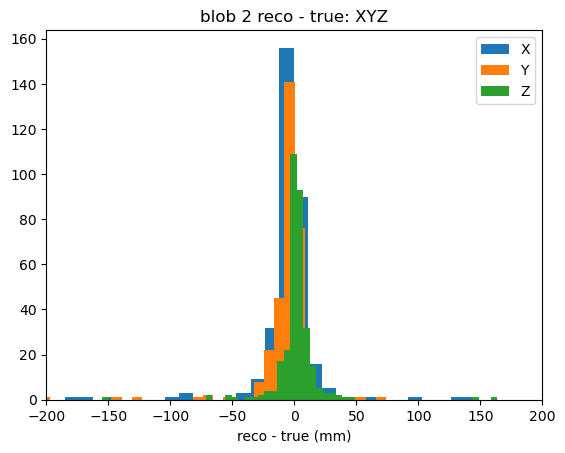

In [205]:
plt.hist([mags.b2_xyz[i][0] for i in range(len(mags.b2_xyz))], bins = 100, label = 'X')
plt.hist([mags.b2_xyz[i][1] for i in range(len(mags.b2_xyz))], bins = 100, label = 'Y')
plt.hist([mags.b2_xyz[i][2] for i in range(len(mags.b2_xyz))], bins = 100, label = 'Z')
plt.title('blob 2 reco - true: XYZ')
#plt.xscale('log')
plt.xlim([-200, 200])
plt.legend()
plt.xlabel('reco - true (mm)')

In [167]:
display(len(mags[mags.blob2_magnitude > 20].index))
display(len(mags[mags.blob1_magnitude > 20].index))

87

55

In [169]:
display(mags[mags.blob1_magnitude > 20])

,Event,blob1_magnitude,blob2_magnitude
1,2,32.514222,9.157729
3,6,608.992010,619.563523
19,38,94.564359,175.132734
28,56,24.559942,15.826001
34,68,20.565183,55.211213
36,72,34.283023,7.443597
42,84,44.811483,15.697341
51,102,34.394985,13.772772
54,108,20.748755,6.973743
58,116,22.417864,5.192265


In [170]:
display(mags[mags.blob2_magnitude > 20])

,Event,blob1_magnitude,blob2_magnitude
3,6,608.992010,619.563523
4,8,5.975628,34.186109
6,12,6.370241,129.953035
7,14,15.282538,21.121756
9,18,5.306815,23.254816
...,...,...,...
312,624,6.779739,58.784652
313,626,13.073292,43.919395
314,628,331.838486,324.327127
319,638,14.166890,41.373070


In [178]:
def display_event_blobs(evt, dataf, dataMCf, track_dataf, extremesf):
    '''
    evt         -  event number 
    dataf        - the DECO data
    dataMCf      - the MC hits
    track_dataf  - the tracking information from isaura
    extremesf    - the extremes dataframe
    '''

    
    events = np.unique(dataf.event.to_numpy())

    # select an event
    evtMC = evt // 2
    print("Selected event: {} ({} MC)".format(evt, evtMC))

    data = dataf[dataf.event == evt]
    track_data = track_dataf[track_dataf.event == evt]
    dataMC = dataMCf[dataMCf.event_id == evtMC]
    evnt_infoMC = infoMC[infoMC.event_id == evtMC]

    evnt_mc_extr = extremesf[extremesf.event_id == evtMC]



    x = data.X
    y = data.Y
    z = data.Z
    e = data.E

    xt = dataMC.x
    yt = dataMC.y
    zt = dataMC.z
    et = dataMC.energy*1000

    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111, projection='3d')
    

    em = e > 0.00005
    ##p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    p = ax.scatter3D(x, y, z, c=e, alpha=0.009, cmap='viridis', zorder=1)
    q = ax.scatter3D(xt, yt, zt, alpha = 0.03, color = 'red', zorder = 0)
    #cb = fig.colorbar(p, ax=ax)
    #cb.set_label('Energy (keV)')


    ax.scatter3D(track_data.blob1_x.values[0], track_data.blob1_y.values[0], track_data.blob1_z.values[0], s = 300, c = 'fuchsia', marker = 'o', zorder = 100, label = 'predicted blob1',depthshade=False)
    ax.scatter3D(track_data.blob2_x.values[0], track_data.blob2_y.values[0], track_data.blob2_z.values[0], s = 350, c = 'red', marker = 'o', zorder = 100, label = 'predicted blob2', depthshade=False)
    for blb, dfext in evnt_mc_extr.groupby('ext'):

        if blb == 1:
            col = 'lime'
        else:
            col = 'navy'
        ax.scatter3D(dfext.x.values[0], dfext.y.values[0], dfext.z.values[0], s = 200, c = col, marker = 'X', label = 'true blob' + str(blb))


    plt.legend()

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')

    #ax.view_init(20, 270)


    # blob parts

    fig.suptitle('3D_deconvolved_plot_' + str(evt))

Selected event: 628 (314 MC)


,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
2773435,628,0.0,187.875,256.575,124.149367,0.000031,196.266318,251.703461,6.282699e+08,0,0,0
2773436,628,0.0,187.875,257.575,124.149367,0.000032,196.266318,251.703461,6.282699e+08,0,0,0
2773437,628,0.0,187.875,258.575,124.149367,0.000031,196.266318,251.703461,6.282699e+08,0,0,0
2773438,628,0.0,188.875,251.575,124.149367,0.000031,196.266318,251.703461,6.282699e+08,0,0,0
2773439,628,0.0,188.875,252.575,124.149367,0.000035,196.266318,251.703461,6.282699e+08,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2775771,628,1.0,-68.125,127.575,276.040242,0.000020,-67.837206,122.434433,6.282699e+08,0,0,0
2775772,628,1.0,-67.125,123.575,276.040242,0.000016,-67.837206,122.434433,6.282699e+08,0,0,0
2775773,628,1.0,-67.125,124.575,276.040242,0.000018,-67.837206,122.434433,6.282699e+08,0,0,0
2775774,628,1.0,-67.125,125.575,276.040242,0.000018,-67.837206,122.434433,6.282699e+08,0,0,0


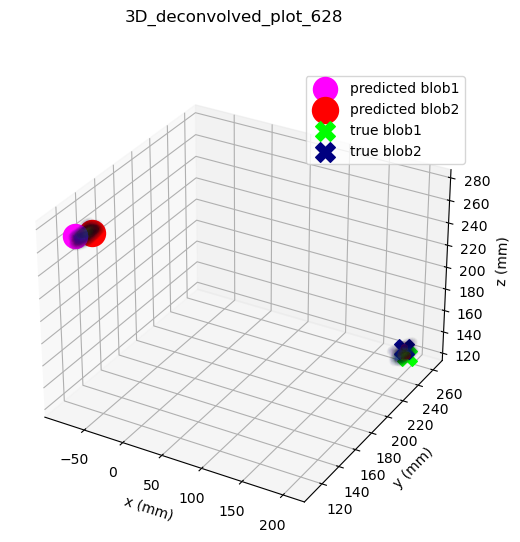

In [181]:
display_event_blobs(628, df, dfMC, tracking, mc_extr)

### lets look at events across different z-values

so lets do z-mean against x_reco - x_true

In [235]:
tracking_1s = tracking.groupby('event').first()
display(tracking_1s.z_ave)

full_mags = mags.copy(deep = True)
full_mags['z_ave'] = tracking_1s.z_ave.to_numpy()

display(full_mags)

event
0      785.055914
2      551.237790
4      418.274413
6      817.042486
8      697.481037
          ...    
640    938.227141
642    900.632717
644    128.234173
646    530.553966
648     42.743596
Name: z_ave, Length: 325, dtype: float64

,Event,blob1_magnitude,blob2_magnitude,b1_xyz,b2_xyz,z_ave
0,0,7.647491,12.973430,"[-6.106189437450439, 4.599152995179935, 0.2153...","[6.537960048044567, -10.787948717495794, -3.03...",785.055914
1,2,32.514222,9.157729,"[22.510516646783344, 1.7565783473934573, -23.3...","[4.351899081149384, 4.631847184403, 6.59325139...",551.237790
2,4,14.261100,3.833415,"[-11.692457778087828, -5.851830121960944, 5.69...","[-2.054151931014303, 3.236403868148045, 0.0348...",418.274413
3,6,608.992010,619.563523,"[366.19579317655246, -319.6456477989702, 366.8...","[368.14857685924807, -336.53606365405074, 367....",817.042486
4,8,5.975628,34.186109,"[5.71206743911813, 1.2770223119747754, -1.2040...","[-1.4597463395983254, -31.844858733221145, 12....",697.481037
...,...,...,...,...,...,...
320,640,9.247886,16.585402,"[-3.203670261454846, -7.902325030613639, 3.579...","[5.1602578738161355, 15.146748765769075, -4.36...",938.227141
321,642,3.534671,20.600185,"[1.9442511474833282, 2.2229221743241965, -1.94...","[11.495405974172058, -9.126445053980802, 14.45...",900.632717
322,644,5.870487,8.374334,"[-3.1528924892589316, -4.929159074795052, 0.47...","[0.1383734959118783, 7.709468032204654, 3.2671...",128.234173
323,646,9.478795,2.860697,"[-8.327025583703232, -4.472446310471298, 0.710...","[2.238749964659064, 1.611575019342439, -0.7578...",530.553966


In [248]:
y_plot = [mags.b1_xyz[i][0] for i in range(len(mags.b1_xyz))]
x_plot = full_mags.z_ave.to_numpy()

Text(0, 0.5, 'reco - true')

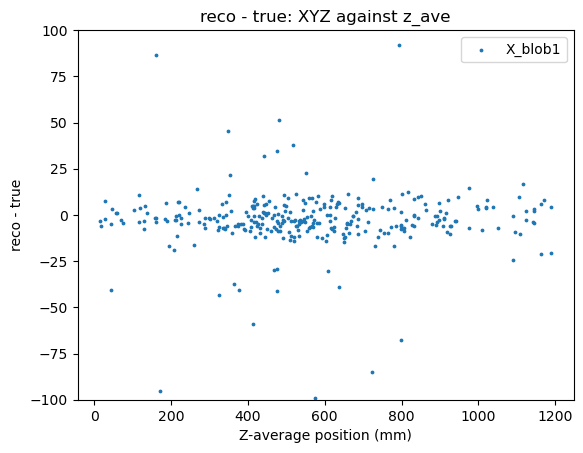

In [264]:
plt.scatter(x_plot, y_plot, label = 'X_blob1', s = 3)
#plt.scatter(x_plot, [mags.b2_xyz[i][0] for i in range(len(mags.b2_xyz))], label = 'X_blob2', s = 3, c = 'orange')

plt.title('reco - true: XYZ against z_ave')
plt.ylim([-100, 100])
plt.legend()
plt.xlabel('Z-average position (mm)')
plt.ylabel('reco - true')